# Le module `pandas` (2/2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['savefig.dpi'] = 80

print(pd.__version__)
pd.options.mode.copy_on_write = True  # compatibilité avec pandas 3

2.2.3


**Exercice 1 : données météorologiques**

> 1. Chargez le fichier `synop_1996_2024_temp.csv.gz` dans une `DataFrame` (l'extension `.gz` ne pose pas de problème et permet de manipuler des fichiers compressés donc moins volumineux). Utilisez la colonne "num" comme index.
> 2. Chargez également le fichier `synop_stations.csv` afin d'avoir des informations sur les stations de mesure. Utilisez la colonne "ID" comme index.
> 3. Affichez les trois premières lignes des deux `DataFrame` créées ainsi que leurs dimensions.

Ces données proviennent de [https://donneespubliques.meteofrance.fr](https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32). Pour alléger la taille des fichiers, seules les mesures de température ont été conservées. Etant donné le nombre de lignes du fichier contenant les mesures, il ne pourrait pas être ouvert avec un tableur.

In [4]:
df_temp = pd.read_csv("TP10_synop_1996_2024_temp.csv.gz", sep=",")

In [5]:
print(f"Taille du DataFrame : {df_temp.shape}")
print(df_temp.columns)
df_temp.set_index("num", inplace=True)
display(df_temp.head(10))

Taille du DataFrame : (4865005, 4)
Index(['num', 'numer_sta', 'date', 't'], dtype='object')


numer_sta            date           t
num                                       
0         7005  19960101000000  276.040000
1         7015  19960101000000  275.950000
2         7020  19960101000000  281.650000
3         7027  19960101000000  279.040000
4         7037  19960101000000  278.540000
5         7110  19960101000000  283.850000
6         7130  19960101000000  281.250000
7         7139  19960101000000  280.150000
8         7149  19960101000000  278.850000
9         7168  19960101000000  279.540000

In [6]:
df_stations = pd.read_csv("TP10_synop_stations.csv", sep=";")
print(f"Taille du DataFrame : {df_stations.shape}")
print(df_stations.columns)
df_stations.set_index("ID", inplace=True)
display(df_stations.head(10))

Taille du DataFrame : (62, 5)
Index(['ID', 'Nom', 'Latitude', 'Longitude', 'Altitude'], dtype='object')


Nom   Latitude  Longitude  Altitude
ID                                                     
7005          ABBEVILLE  50.136000   1.834000        69
7015      LILLE-LESQUIN  50.570000   3.097500        47
7020    PTE DE LA HAGUE  49.725167  -1.939833         6
7027     CAEN-CARPIQUET  49.180000  -0.456167        67
7037         ROUEN-BOOS  49.383000   1.181667       151
7072       REIMS-PRUNAY  49.209667   4.155333        95
7110     BREST-GUIPAVAS  48.444167  -4.412000        94
7117        PLOUMANAC'H  48.825833  -3.473167        55
7130  RENNES-ST JACQUES  48.068833  -1.734000        36
7139            ALENCON  48.445500   0.110167       143

> 4. Tracez sur une carte les positions des stations de mesure. Vous pouvez vous inspirer de ce que vous avez fait pour le TP `pandas` précédent.

In [7]:
def latlon_lambert93(lat,lon):
    lat_rad, lon_rad = lat*np.pi/180, lon*np.pi/180
    ## lat,lon => projection en Lambert 93 (X,Y)
    ee = 0.08181919104281579 # Première excentricité de l'ellipsoïde GRS80
    lat0, lon0 = 46.5, 3. # en degrés, la longitude d'origine correspond à l'Est (Greenwich)
    lat0_rad, lon0_rad = lat0*np.pi/180, lon0*np.pi/180
    X0, Y0 = 700000, 12655612.049876 # coordonnées en projection du pôle
    lat_iso = np.log(np.tan(np.pi/4+lat_rad/2)*((1-ee*np.sin(lat_rad))/(1+ee*np.sin(lat_rad)))**(ee/2))
    C = 11754255.426096 # constante de la projection 
    n = 0.7256077650532670 # exposant de la projection
    Xl93 = X0 + C*np.exp(-n*lat_iso)*np.sin(n*(lon_rad-lon0_rad))
    Yl93 = Y0 - C*np.exp(-n*lat_iso)*np.cos(n*(lon_rad-lon0_rad))
    return Xl93, Yl93

In [8]:
df_stations[["X", "Y"]] = df_stations.apply(
    lambda x: latlon_lambert93(x["Latitude"], x["Longitude"]),
    axis=1, result_type='expand'
)
df_stations.head(5)

Nom   Latitude  Longitude  Altitude              X  \
ID                                                                     
7005        ABBEVILLE  50.136000   1.834000        69  616551.369373   
7015    LILLE-LESQUIN  50.570000   3.097500        47  706918.470509   
7020  PTE DE LA HAGUE  49.725167  -1.939833         6  343822.995818   
7027   CAEN-CARPIQUET  49.180000  -0.456167        67  448062.771671   
7037       ROUEN-BOOS  49.383000   1.181667       151  567942.002153   

                 Y  
ID                  
7005  7.004814e+06  
7015  7.052543e+06  
7020  6.969607e+06  
7027  6.903321e+06  
7037  6.921909e+06

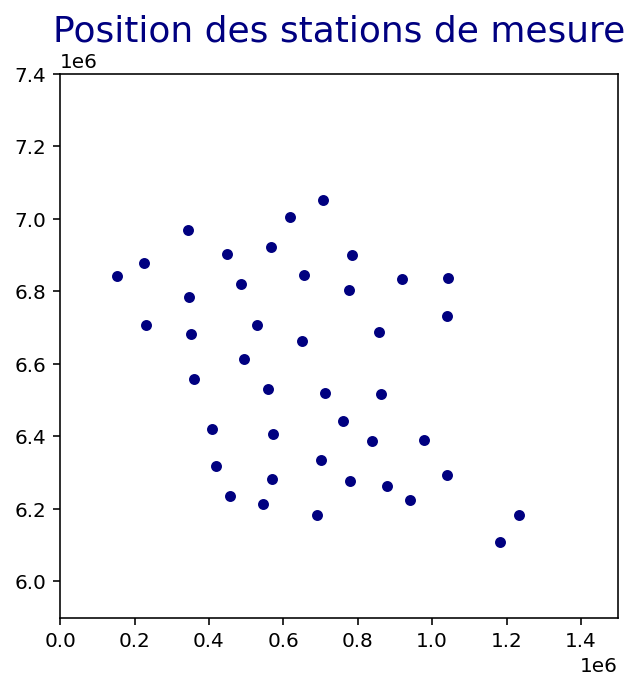

In [9]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_stations["X"], df_stations["Y"], s=20, c='navy')
ax.set_xlim(0, 1.5e6)
ax.set_ylim(5.9e6, 7.4e6)
ax.set_title("Position des stations de mesure", color='navy', fontsize=18);

> 5. Convertir la colonne où se trouvent les dates des mesures au format `datetime64`.
><div class="alert alert-block alert-info">
><b>Indication : </b> 
>Utilisez <a href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">pd.to_datetime</a> pour la conversion.
></div>

In [10]:
# help(pd.to_datetime)
print(f"Exemple de date {df_temp['date'].iloc[0]}")
df_temp["date"] = pd.to_datetime(df_temp["date"], format="%Y%m%d%H%M%S")
display(df_temp.head(10))
display(df_temp.at[0, 'date'])

Exemple de date 19960101000000


numer_sta       date           t
num                                  
0         7005 1996-01-01  276.040000
1         7015 1996-01-01  275.950000
2         7020 1996-01-01  281.650000
3         7027 1996-01-01  279.040000
4         7037 1996-01-01  278.540000
5         7110 1996-01-01  283.850000
6         7130 1996-01-01  281.250000
7         7139 1996-01-01  280.150000
8         7149 1996-01-01  278.850000
9         7168 1996-01-01  279.540000

num
0   1996-01-01
0   1996-02-01
0   1996-03-01
0   1996-04-01
0   1996-05-01
       ...    
0   2024-07-01
0   2024-08-01
0   2024-09-01
0   2024-10-01
0   2024-11-01
Name: date, Length: 347, dtype: datetime64[ns]

In [11]:
print(df_temp.iat[100, 1])

1996-01-01 03:00:00


> 6. Pour certaines lignes la température indiquée est "mq" ce qui signifie que la donnée est manquante. Ne conservez pas ces lignes dans la DataFrame. Convertissez ensuite la colonne des températures de type "object" en valeurs numériques (float). 
><div class="alert alert-block alert-info">
><b>Indication : </b> 
>Pour la conversion vous pouvez utiliser <a href="https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html">pd.to_numeric</a> 
></div>

In [12]:
# combien de lignes au départ
Ni = df_temp.shape[0]
df_temp = df_temp.loc[df_temp["t"] != 'mq']
# combien de lignes à l'arrivée !
Nf = df_temp.shape[0]
print(f"On a supprimé {Ni-Nf} lignes")

On a supprimé 24998 lignes


> 7. Ajoutez une colonne que l'on appelera "temp" avec la température en degré Celsius (soit la température en Kelvin moins 273.15).

In [13]:
df_temp["temp"] = pd.to_numeric(df_temp["t"]) - 273.15
df_temp.head(10)

numer_sta       date           t   temp
num                                         
0         7005 1996-01-01  276.040000   2.89
1         7015 1996-01-01  275.950000   2.80
2         7020 1996-01-01  281.650000   8.50
3         7027 1996-01-01  279.040000   5.89
4         7037 1996-01-01  278.540000   5.39
5         7110 1996-01-01  283.850000  10.70
6         7130 1996-01-01  281.250000   8.10
7         7139 1996-01-01  280.150000   7.00
8         7149 1996-01-01  278.850000   5.70
9         7168 1996-01-01  279.540000   6.39

> 8.1 Créez une `DataFrame` ne contenant que les lignes concernant la station nommée `ORLY`.
><div class="alert alert-block alert-info">
><b>Indications : </b> 
>Commencez par rechercher l'ID de la station d'ORLY dans la DataFrame des stations. Utilisez ensuite cet ID pour filtrer les données de températures.
></div>
> 8.2 Utilisez la colonne "date" comme index pour la `DataFrame` `ORLY` et assurez-vous que toutes les lignes sont bien dans l'ordre chronologique. 
><div class="alert alert-block alert-info">
><b>Indication : </b> 
>Pour trier l'index d'une DataFrame vous pouvez utiliser : <a href="https://pandas.pydata.org/docs/reference/api/pandas.Index.sort_values.html">pd.index.sort_values</a> avec l'argument "return_indexer=True" afin de pouvoir récupérer le nouvel ordre et l'appliquer à toutes les colonnes.
></div>
> 8.3 Tracez l'évolution de la température mesurée à la station d'Orly

In [14]:
NomStation = "ORLY"
#NomStation = "BREST-GUIPAVAS"
display(df_stations[df_stations["Nom"] == NomStation])
idStation = df_stations[df_stations["Nom"] == NomStation].index[0]
print(f"Le numéro de la station {NomStation} est {idStation}")

Nom   Latitude  Longitude  Altitude              X             Y
ID                                                                     
7149  ORLY  48.716833   2.384333        89  654705.498854  6.846476e+06

Le numéro de la station ORLY est 7149


In [15]:
temp_station = df_temp[df_temp["numer_sta"] == idStation]
print(f"Taille des données pour {NomStation} : {temp_station.shape}")
temp_station.head()

Taille des données pour ORLY : (83918, 4)


numer_sta                date           t  temp
num                                                 
8         7149 1996-01-01 00:00:00  278.850000  5.70
62        7149 1996-01-01 03:00:00  279.040000  5.89
116       7149 1996-01-01 06:00:00  279.350000  6.20
169       7149 1996-01-01 09:00:00  279.250000  6.10
224       7149 1996-01-01 12:00:00  279.850000  6.70

In [16]:
temp_station.set_index("date", inplace=True)
li = list(temp_station.index)
# les indices ne sont pas rangés dans l'ordre
for k in range(1, len(li)):
    if li[k] < li[k-1]:
        print("Problème avant sort")
temp_station.sort_index(inplace=True)
# Vérification
lf = list(temp_station.index)
for k in range(1, len(lf)):
    if lf[k] < lf[k-1]:
        print("Problème après sort")

Problème avant sort
Problème avant sort
Problème avant sort
Problème avant sort
Problème avant sort
Problème avant sort


In [17]:
temp_station.head()

numer_sta           t  temp
date                                            
1996-01-01 00:00:00       7149  278.850000  5.70
1996-01-01 03:00:00       7149  279.040000  5.89
1996-01-01 06:00:00       7149  279.350000  6.20
1996-01-01 09:00:00       7149  279.250000  6.10
1996-01-01 12:00:00       7149  279.850000  6.70

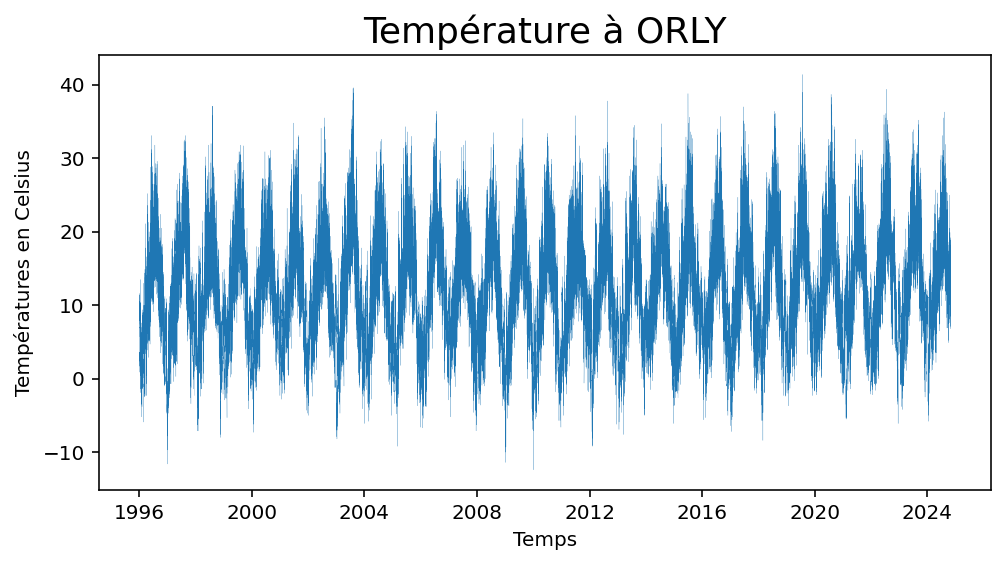

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(temp_station["temp"], linewidth=.1)
ax.set_title(f"Température à {NomStation}", fontsize=18)
ax.set_xlabel("Temps")
ax.set_ylabel("Températures en Celsius")
plt.show()

> 8.4 Au lieu d'avoir une mesure de température toutes les 3h, on souhaite avoir une valeur moyenne par jour. Créez une nouvelle DataFrame contenant ces valeurs moyennes journalières et tracez le graphe des températures.
> 
><div class="alert alert-block alert-info">
><b>Indication : </b> 
>Vous pouvez vous inspirer de ce fil de discussion (ancien) <a href="https://stackoverflow.com/questions/52599774/compute-daily-mean-with-pandas">compute-daily-mean-with-pandas</a> ou bien utiliser la commande <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html">resample</a>.
></div>

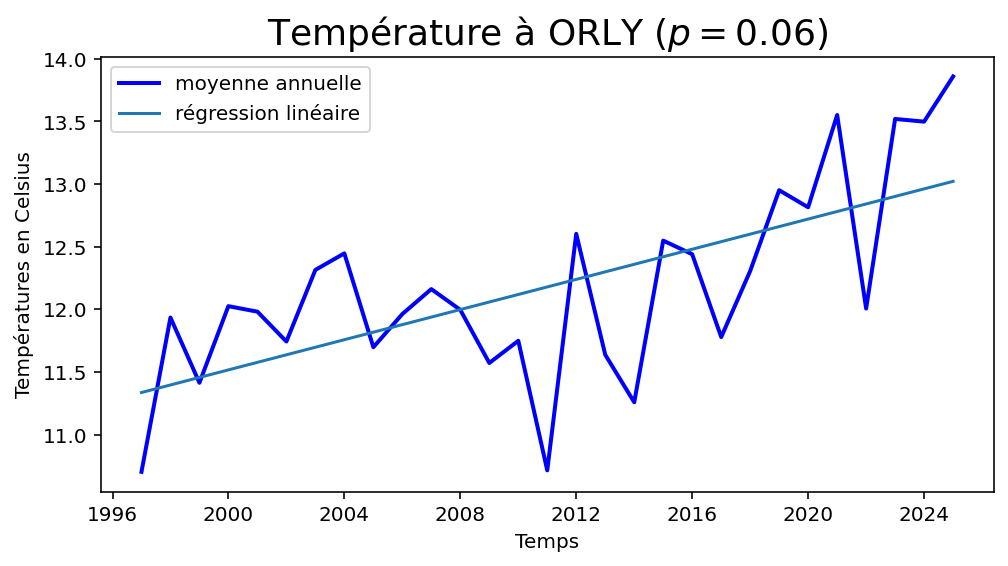

In [19]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
moy_ann = temp_station["temp"].resample('YE', label='right').mean()
ax.plot(moy_ann, linewidth=2, alpha=1, color='blue', label='moyenne annuelle')
p, c = np.polyfit(moy_ann.index.year, moy_ann.values, deg=1)
ax.plot(moy_ann.index, c + p*moy_ann.index.year, label='régression linéaire')
#ax.plot(temp_station["temp"], linewidth=.1, alpha=0.25, color='orange', label='data')
#ax.plot(temp_station["temp"].resample('D').mean(), linewidth=.2, alpha=0.25, color='red', label='moyenne journalière')
#ax.plot(temp_station["temp"].resample('W').mean(), linewidth=.2, alpha=0.25, color='green', label='moyenne hebdomadaire')
#ax.plot(temp_station["temp"].resample('ME').mean(), linewidth=1, alpha=0.5, color='navy', label='moyenne mensuelle')
ax.set_title(f"Température à {NomStation} ($p={p:4.2f}$)", fontsize=18)
ax.set_xlabel("Temps")
ax.set_ylabel("Températures en Celsius")
ax.legend()
plt.show()

> 9.1 [difficile] En faisant avec les autres stations métropolitaine ce qui vient d'être fait pour la station d'Orly, construisez la DataFrame suivante :
>
>|             | ABBEVILLE  | LILLE-LESQUIN  | PTE DE LA HAGUE  | ...  |
>|      ---    |     ---    |     ---        |    ---           | ---  |
>| 1996-01-01  | 3.47000	| 2.90000	     |   8.78625        | ...  |
>| 1996-01-02  | 2.58375	| 1.11000	     |   8.86000        | ...  |
>| 1996-01-03  | 1.38250	| -0.07875	     |   7.35875        | ...  |
>| ...         | ...        | ...            | ...              | ...  |


In [44]:
mask_metro = (df_stations["X"] >= 0) * (df_stations["X"] <= 1.5e6) * (df_stations["Y"] >= 5.9e6) * (df_stations["Y"] <= 7.4e6)
lst_stations = df_stations.loc[mask_metro, 'Nom']
# print(lst_stations)

date_index = pd.date_range(start=df_temp["date"].min(), end=df_temp["date"].max(), freq='YE')
tab = pd.DataFrame(index=date_index, columns=lst_stations.values)

for NomStation in lst_stations.values:
    #display(df_stations[df_stations["Nom"] == NomStation])
    idStation = df_stations[df_stations["Nom"] == NomStation].index[0]
    #print(f"Le numéro de la station {NomStation} est {idStation}")
    temp_station = df_temp[df_temp["numer_sta"] == idStation]
    #print(f"Taille des données pour {NomStation} : {temp_station.shape}")
    temp_station.set_index("date", inplace=True)
    temp_station.sort_index(inplace=True)
    moy_station = temp_station["temp"].resample('YE', label='right').mean()
    tab[NomStation] = moy_station
    
display(tab)

ABBEVILLE  LILLE-LESQUIN  PTE DE LA HAGUE  CAEN-CARPIQUET  \
1996-12-31   9.061223       9.311514        11.292499       10.180158   
1997-12-31  10.539969      10.958025        12.036363       11.229852   
1998-12-31  10.545632      10.756319        12.152368       11.148717   
1999-12-31  11.141223      11.434924        12.593025       11.814513   
2000-12-31  10.941591      11.263642        12.110726       11.454978   
2001-12-31  10.600278      10.936788        12.291886       11.388122   
2002-12-31  10.945199      11.355552        12.563194       11.769855   
2003-12-31  10.933460      11.261710        12.232619       11.574391   
2004-12-31  10.708588      10.974648        12.297671       11.222146   
2005-12-31  10.789589      11.140789        12.340636       11.235953   
2006-12-31  11.081712      11.394441        12.245765       11.520185   
2007-12-31  11.078380      11.473850        12.589820       11.265600   
2008-12-31  10.623788      10.953986        12.118392       11.005748   
2009-12-31  10.651562      11.001371        11.940508       11.003325   
2010-12-31   9.447841       9.791283        11.141160       10.079890   
2011-12-31  11.517388      11.668977        12.357750       11.796192   
2012-12-31  10.404737      10.709990        11.912326       10.865777   
2013-12-31  10.086082      10.289007        11.472404       10.636507   
2014-12-31  11.686054      11.948424        12.978957       11.910588   
2015-12-31  11.274751      11.382968        12.427731       11.570314   
2016-12-31  10.921292      11.162756        12.218572       11.152541   
2017-12-31  11.456067      11.655521        12.751645       11.705363   
2018-12-31  11.557354      11.952812        12.319087       11.643139   
2019-12-31  11.505668      11.793416        12.982266       11.575129   
2020-12-31  12.129211      12.448753        12.748377       12.186799   
2021-12-31  10.929851      11.034784        12.173712       11.259459   
2022-12-31  12.040569      12.451250        13.203090       12.352796   
2023-12-31  12.084430      12.430796        13.042486       12.451588   

            ROUEN-BOOS  REIMS-PRUNAY  BREST-GUIPAVAS  PLOUMANAC'H  \
1996-12-31    9.299753           NaN       10.792368    11.510832   
1997-12-31   10.696331           NaN       11.916129    13.139271   
1998-12-31   10.337822           NaN       11.407053    11.959416   
1999-12-31   11.040525           NaN       11.859966    12.333960   
2000-12-31   10.717110           NaN       11.368580    12.012553   
2001-12-31   10.551549           NaN       11.313981    12.067858   
2002-12-31   10.922207           NaN       11.771839    12.350874   
2003-12-31   11.025133           NaN       11.816804    12.262509   
2004-12-31   10.408827           NaN       11.396127    11.872322   
2005-12-31   10.700173           NaN       11.562180    12.180870   
2006-12-31   10.942940           NaN       11.827993    12.171968   
2007-12-31   10.892566           NaN       11.695536    12.207873   
2008-12-31   10.427158           NaN       11.216655    11.884621   
2009-12-31   10.640909           NaN       11.335893    11.819133   
2010-12-31    9.570094           NaN       10.523635    11.106669   
2011-12-31   11.355329           NaN       12.065764    12.504421   
2012-12-31   10.423024     13.035861       11.327139    11.709059   
2013-12-31   10.005145     10.150034       11.270120    11.561887   
2014-12-31   11.481968     11.560877       12.270649    12.864787   
2015-12-31   11.198488     11.362461       11.960761    12.439356   
2016-12-31   10.703460     10.669041       11.635705    12.135123   
2017-12-31   11.217944     11.116494       11.716678    12.434089   
2018-12-31   11.569307     11.868027       11.810763    12.246536   
2019-12-31   11.366690     11.424220       11.792081    12.339384   
2020-12-31   11.976282     12.157573       12.247777    12.719615   
2021-12-31   10.576965     10.703195       11.585401    12.115818   
2022-12-31   12.000277     12.1

>9.2 Tracez l'évolution de la température moyenne en France métropolitaine. 

In [83]:
def colorise(station):
    mask = df_stations["Nom"] == station
    mask_metro = (df_stations["X"] >= 0) * (df_stations["X"] <= 1.5e6) * (df_stations["Y"] >= 5.9e6) * (df_stations["Y"] <= 7.4e6)
    X, Y = df_stations.loc[mask, "X"].iloc[0], df_stations.loc[mask, "Y"].iloc[0]
    minX, maxX = df_stations.loc[mask_metro, "X"].min(), df_stations.loc[mask_metro, "X"].max()
    minY, maxY = df_stations.loc[mask_metro, "Y"].min(), df_stations.loc[mask_metro, "Y"].max()
    x, y = (X-minX)/(maxX-minX), (Y-minY)/(maxY-minY)
    return (1-y, 0, y)

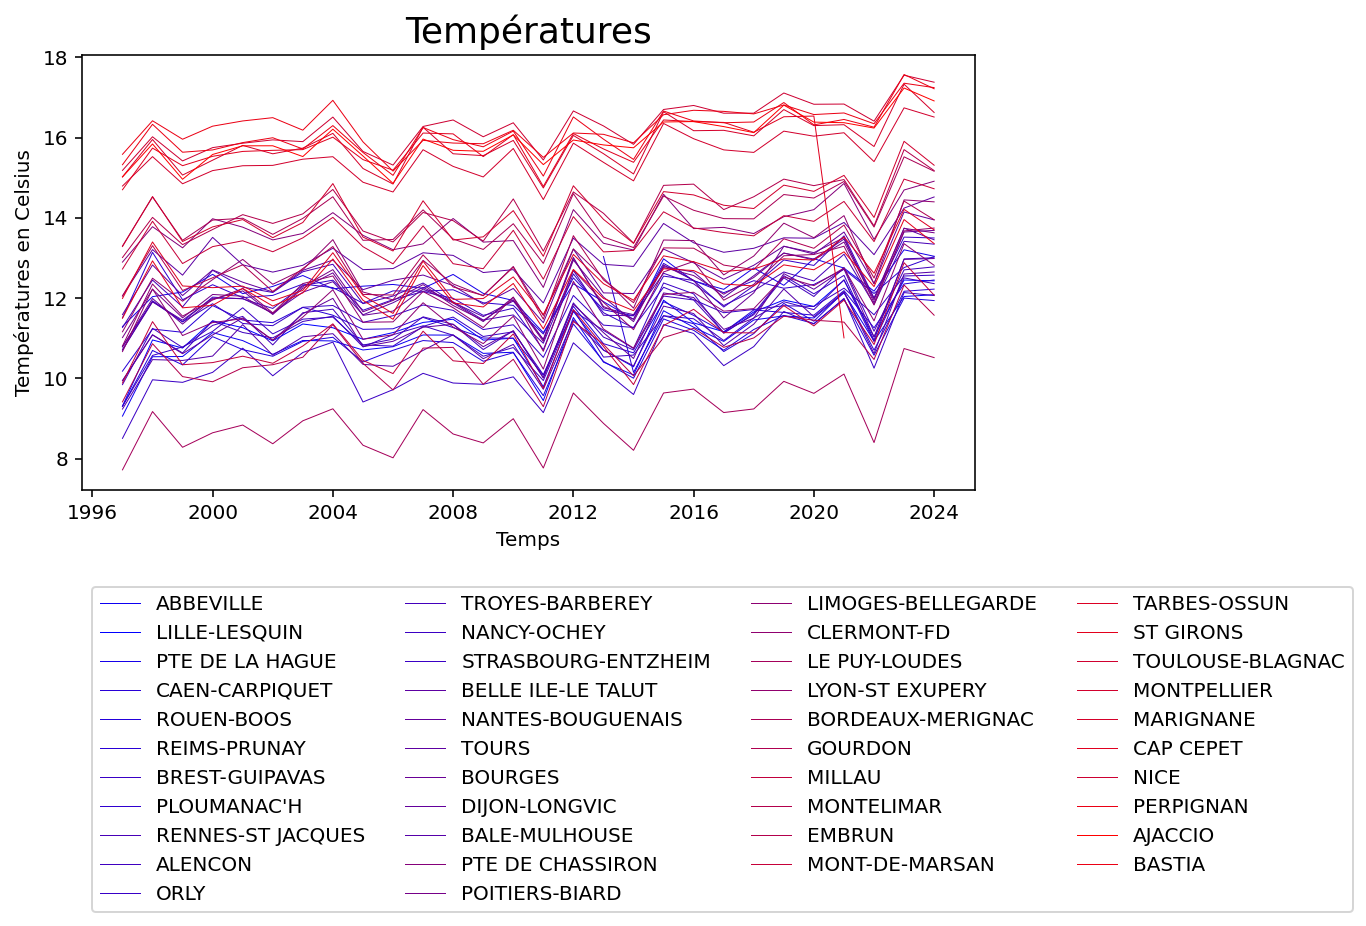

In [84]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
for station in tab.columns:
    #print(station)
    ax.plot(tab[station], label=station, alpha=1, linewidth=0.5, color=colorise(station))

ax.set_title("Températures", fontsize=18)
ax.set_xlabel("Temps")
ax.set_ylabel("Températures en Celsius")
ax.legend(loc='upper left', bbox_to_anchor=(0, -.2), ncols=4)
plt.show()

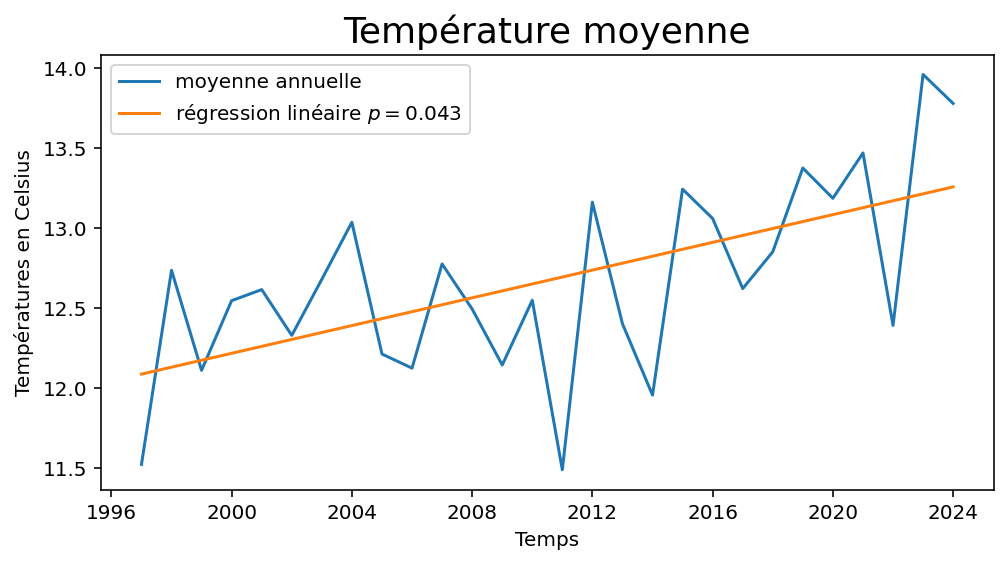

In [32]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot(tab.mean(axis=1), label='moyenne annuelle')
p, c = np.polyfit(tab.index.year, tab.mean(axis=1).values, deg=1)
ax.plot(tab.index, c + p*tab.index.year, label=f'régression linéaire $p={p:5.3f}$')

ax.set_title("Température moyenne", fontsize=18)
ax.set_xlabel("Temps")
ax.set_ylabel("Températures en Celsius")
ax.legend()
plt.show()

>9.3[hors programme...] Peut-on dire que les températures journalières des stations sont corrélées ? 